```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 最大似然估计

```{contents} 目录
:depth: 2
```

## 概述

在{doc}`之前的讲座 <ols>`中，我们使用线性回归估计了因变量和解释变量之间的关系。

但如果线性关系不适合我们的模型假设呢？

一个广泛使用的替代方法是最大似然估计，它涉及指定一类由未知参数索引的分布，然后使用数据来确定这些参数值。

与线性回归相比，其优势在于它允许变量之间有更灵活的概率关系。

在这里，我们通过复现Daniel Treisman（2016）的论文[《俄罗斯的亿万富翁》](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068)来说明最大似然法。该论文将一个国家的亿万富翁数量与其经济特征联系起来。

该论文得出结论：俄罗斯的亿万富翁数量高于经济因素（如市场规模和税率）所预测的水平。

我们需要以下导入：

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

### 预备知识

我们假设读者熟悉基本概率论和多元微积分。

## 设置和假设

让我们考虑最大似然估计所需的步骤以及它们与本研究的关系。

### 思路流程

最大似然估计的第一步是选择被认为产生数据的概率分布。

更准确地说，我们需要对产生数据的*参数分布族*做出假设。

* 例如，所有正态分布的类别，或所有伽马分布的类别。

每个这样的类别都是由有限个参数索引的分布族。

* 例如，正态分布类是由其均值 $\mu \in (-\infty, \infty)$ 和标准差 $\sigma \in (0, \infty)$ 索引的分布族。

我们将让数据通过确定参数来选择类别中的特定元素。

以这种方式产生的参数估计被称为**最大似然估计**。

### 统计亿万富豪

Treisman {cite}`Treisman2016` 致力于估计不同国家的亿万富豪数量。

亿万富豪的数量是整数值。

因此我们考虑仅取非负整数值的分布。

（这是最小二乘回归不是当前问题最佳工具的原因之一，因为线性回归中的因变量不限于整数值）

[泊松分布](https://en.wikipedia.org/wiki/Poisson_distribution)是一种整数分布，其概率质量函数（pmf）为

$$
f(y) = \frac{\mu^{y}}{y!} e^{-\mu},
\qquad y = 0, 1, 2, \ldots, \infty
$$

我们可以按如下方式绘制不同 $\mu$ 值下的泊松分布图

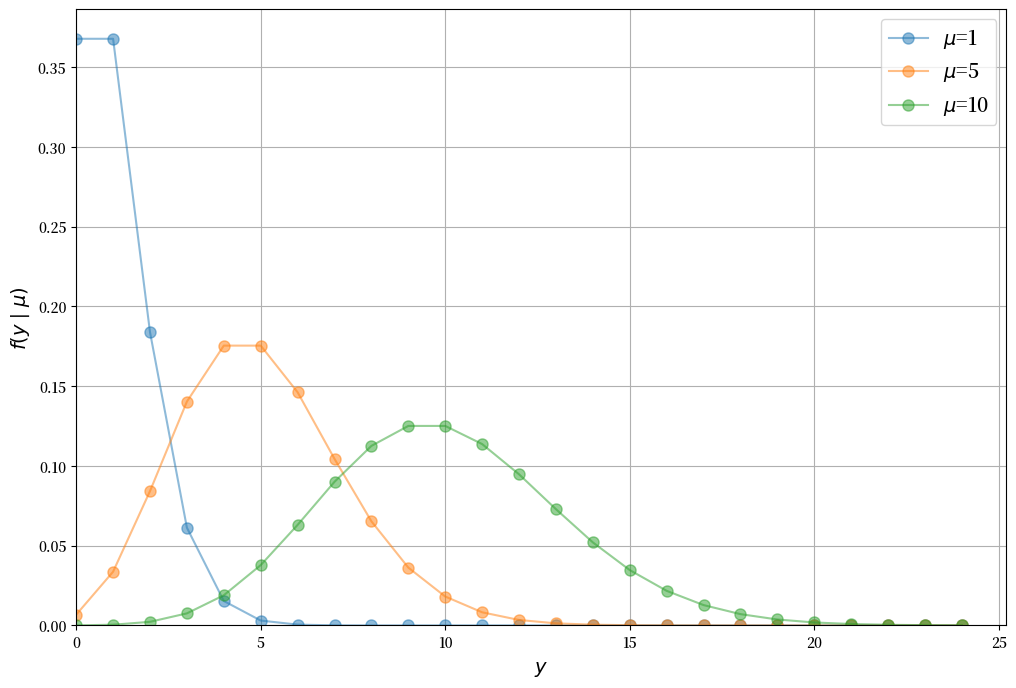

In [2]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=fr'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel(r'$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

注意当 $y$ 的均值增加时，泊松分布开始呈现出类似正态分布的特征。

让我们来看看本讲中我们将要使用的数据分布情况。

Treisman的主要数据来源是《福布斯》年度富豪榜及其估计净资产。

数据集`mle/fp.dta`可以从[这里](https://python.quantecon.org/_static/lecture_specific/mle/fp.dta)
或其[AER页面](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068)下载。

In [3]:
pd.options.display.max_columns = 10

# 加载数据并查看
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


通过直方图，我们可以查看2008年各国亿万富翁人数`numbil0`的分布情况（为了绘图目的，已排除美国数据）

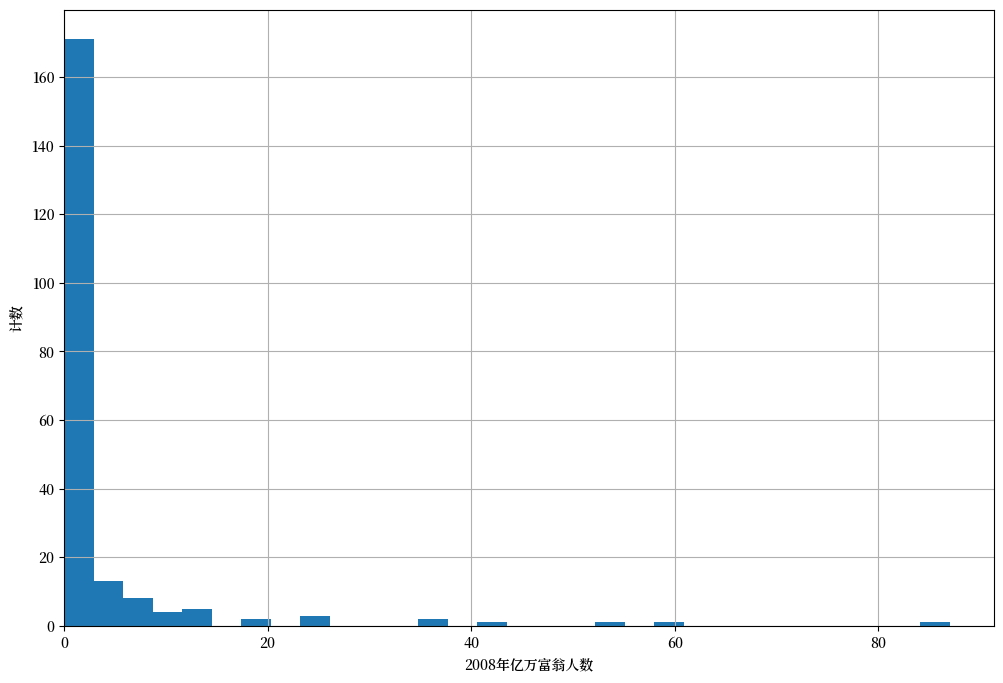

In [4]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('2008年亿万富翁人数')
plt.ylabel('计数')
plt.show()

从直方图来看，泊松分布的假设似乎是合理的（尽管μ值很低且有一些异常值）。

## 条件分布

在Treisman的论文中，因变量——国家$i$的亿万富翁数量$y_i$——被建模为人均GDP、人口规模以及加入关贸总协定和世贸组织年限的函数。

因此，$y_i$的分布需要以解释变量向量$\mathbf{x}_i$为条件。

标准公式——即所谓的*泊松回归*模型——如下：

```{math}
:label: poissonreg

f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty .
```

$$
\text{其中}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

为了说明$y_i$的分布依赖于$\mathbf{x}_i$这一概念，让我们进行一个简单的模拟。

我们使用上面的`poisson_pmf`函数和任意值的$\boldsymbol{\beta}$和$\mathbf{x}_i$

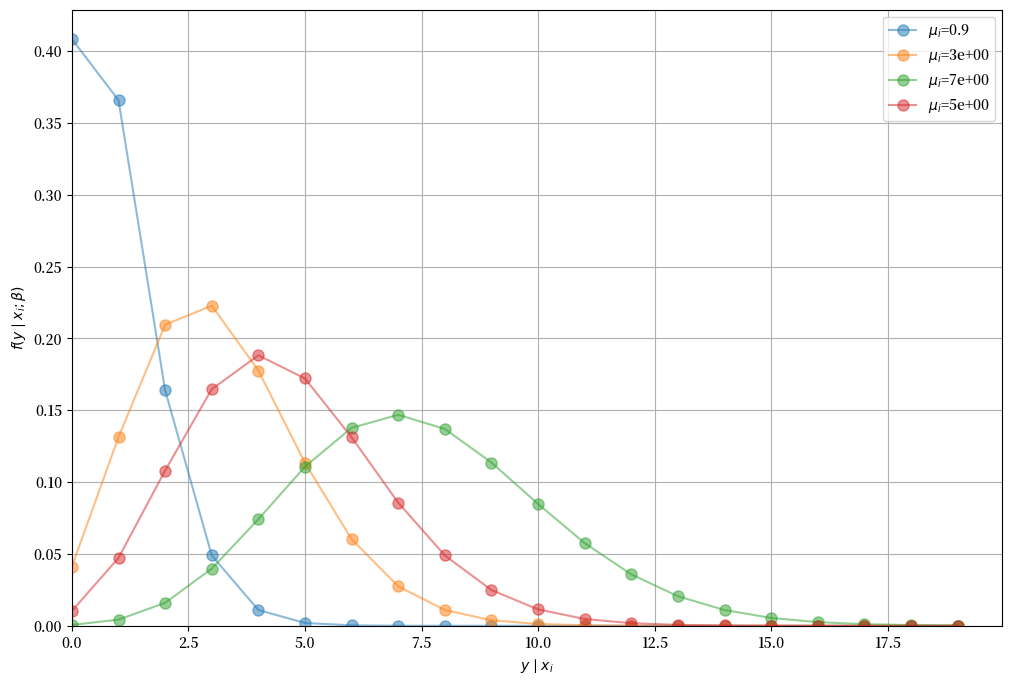

In [5]:
y_values = range(0, 20)

# 定义一个带有估计值的参数向量
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# 创建一些观测值X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=fr'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel(r'$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

我们可以看到 $y_i$ 的分布是以 $\mathbf{x}_i$ 为条件的（$\mu_i$ 不再是常数）。

## 最大似然估计

在我们的亿万富翁数量模型中，条件分布包含4个（$k = 4$）需要估计的参数。

我们将整个参数向量标记为 $\boldsymbol{\beta}$，其中

$$
\boldsymbol{\beta} = \begin{bmatrix}
                            \beta_0 \\
                            \beta_1 \\
                            \beta_2 \\
                            \beta_3
                      \end{bmatrix}
$$

为了使用最大似然估计来估计模型，我们希望最大化我们的估计值 $\hat{\boldsymbol{\beta}}$ 是真实参数 $\boldsymbol{\beta}$ 的似然。

直观地说，我们想要找到最适合我们数据的 $\hat{\boldsymbol{\beta}}$。

首先，我们需要构建似然函数 $\mathcal{L}(\boldsymbol{\beta})$，它类似于联合概率密度函数。

假设我们有一些数据 $y_i = \{y_1, y_2\}$ 且
$y_i \sim f(y_i)$。

如果 $y_1$ 和 $y_2$ 是独立的，这些数据的联合概率质量函数是
$f(y_1, y_2) = f(y_1) \cdot f(y_2)$。

如果 $y_i$ 服从参数为 $\lambda = 7$ 的泊松分布，
我们可以这样可视化联合概率质量函数

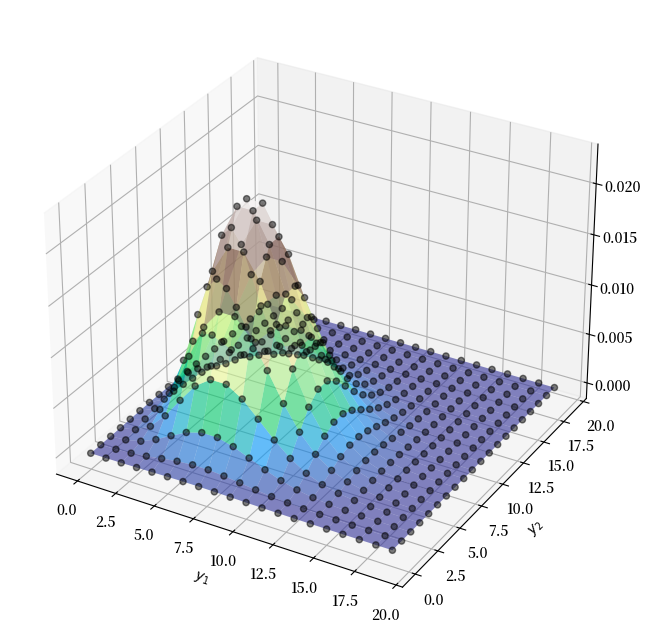

In [6]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # 创建 X 和 Y 的坐标点
    X, Y = np.meshgrid(yi_values, yi_values)

    # 将分布相乘
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

同样，我们的数据（服从条件泊松分布）的联合概率质量函数可以写作：

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
    = \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}
$$

$y_i$ 同时依赖于 $\mathbf{x}_i$ 的值和参数 $\boldsymbol{\beta}$。

似然函数与联合概率质量函数相同，但是将参数 $\boldsymbol{\beta}$ 视为随机变量，并将观测值 $(y_i, \mathbf{x}_i)$ 视为已知：

$$
\begin{split}
\mathcal{L}(\beta \mid y_1, y_2, \ldots, y_n \ ; \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n) = &
\prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i} \\ = &
f(y_1, y_2, \ldots, y_n \mid  \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n ; \beta)
\end{split}
$$

现在我们有了似然函数，我们要找到能使似然值最大的 $\hat{\boldsymbol{\beta}}$

$$

\underset{\boldsymbol{\beta}}{\max} \mathcal{L}(\boldsymbol{\beta})
$$

在这种情况下，最大化对数似然通常更容易（比较求导 $f(x) = x \exp(x)$ 与 $f(x) = \log(x) + x$）。

由于对数是单调递增变换，似然函数的最大值点也是对数似然函数的最大值点。

在我们的例子中，对数似然为

$$
\begin{split}
\log{ \mathcal{L}} (\boldsymbol{\beta}) = \ &
    \log \Big(
        f(y_1 ; \boldsymbol{\beta})
        \cdot
        f(y_2 ; \boldsymbol{\beta})
        \cdot \ldots \cdot
        f(y_n ; \boldsymbol{\beta})
        \Big) \\
        = &
        \sum_{i=1}^{n} \log{f(y_i ; \boldsymbol{\beta})} \\
        = &
        \sum_{i=1}^{n}
        \log \Big( {\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}} \Big) \\
        = &
        \sum_{i=1}^{n} y_i \log{\mu_i} -
        \sum_{i=1}^{n} \mu_i -
        \sum_{i=1}^{n} \log y!
\end{split}
$$

泊松分布的 $\hat{\beta}$ 的最大似然估计可以通过求解以下问题得到：

$$
\underset{\beta}{\max} \Big(
\sum_{i=1}^{n} y_i \log{\mu_i} -
\sum_{i=1}^{n} \mu_i -
\sum_{i=1}^{n} \log y! \Big)
$$

然而，上述问题没有解析解——要找到最大似然估计，我们需要使用数值方法。

## 使用数值方法的最大似然估计

许多分布都没有很好的解析解，因此需要数值方法来求解参数估计。

牛顿-拉夫森算法就是这样一种数值方法。

我们的目标是找到最大似然估计 $\hat{\boldsymbol{\beta}}$。

在 $\hat{\boldsymbol{\beta}}$ 处，对数似然函数的一阶导数将等于0。

让我们通过假设以下函数来说明这一点：

$$
\log \mathcal{L(\beta)} = - (\beta - 10) ^2 - 10
$$

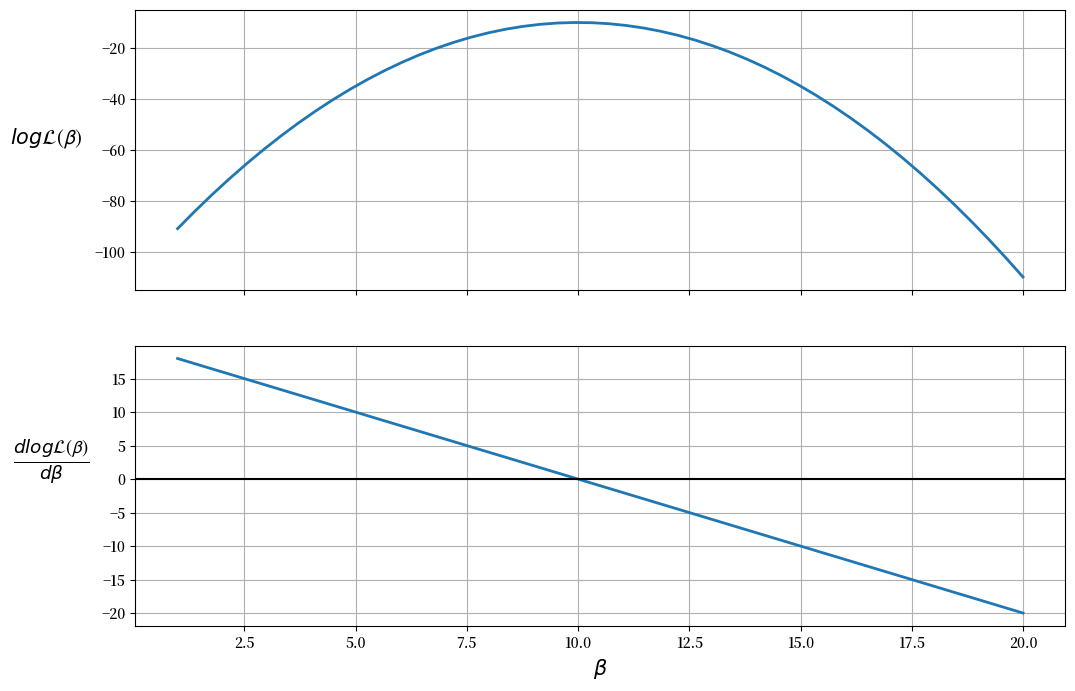

In [7]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

图表显示最大似然值（上图）出现在
$\frac{d \log \mathcal{L(\boldsymbol{\beta})}}{d \boldsymbol{\beta}} = 0$ 时（下图）。

因此，似然函数在 $\beta = 10$ 时达到最大值。

我们还可以通过检查二阶导数（下图的斜率）是否为负来确保这个值是一个*最大值*（而不是最小值）。

牛顿-拉夫森算法用于寻找一阶导数为0的点。

要使用该算法，我们首先对最大值进行初始猜测，
$\beta_0$（OLS参数估计可能是一个合理的猜测），然后

1. 使用更新规则进行迭代

   $$
   \boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} - H^{-1}(\boldsymbol{\beta}_{(k)})G(\boldsymbol{\beta}_{(k)})
   $$
   其中：

   $$
   \begin{aligned}
   G(\boldsymbol{\beta}_{(k)}) = \frac{d \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}} \\

H(\boldsymbol{\beta}_{(k)}) = \frac{d^2 \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}d \boldsymbol{\beta}'_{(k)}}
   \end{aligned}
   $$

1. 检查 $\boldsymbol{\beta}_{(k+1)} - \boldsymbol{\beta}_{(k)} < tol$ 是否成立
    - 如果成立，则停止迭代并设定
      $\hat{\boldsymbol{\beta}} = \boldsymbol{\beta}_{(k+1)}$
    - 如果不成立，则更新 $\boldsymbol{\beta}_{(k+1)}$

从更新方程可以看出，只有当 $G(\boldsymbol{\beta}_{(k)}) = 0$ 时，即一阶导数等于0时，才有 $\boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)}$。

（在实践中，当差异小于一个很小的容差阈值时，我们就停止迭代）

让我们来实现牛顿-拉弗森算法。

首先，我们创建一个名为 `PoissonRegression` 的类，这样我们就可以在每次迭代时轻松重新计算对数似然、梯度和海森矩阵的值

In [8]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # 将y重塑为n_by_1列向量
        self.y = y.reshape(self.n,1)
        # 将β重塑为k_by_1列向量
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

我们的函数`newton_raphson`将接收一个`PoissonRegression`对象，该对象包含参数向量$\boldsymbol{\beta}_0$的初始猜测值。

该算法将根据更新规则更新参数向量，并在新的参数估计值处重新计算梯度和Hessian矩阵。

迭代将在以下情况下结束：

* 参数与更新后参数之间的差异低于容差水平。
* 达到最大迭代次数（意味着未达到收敛）。

为了让我们能够了解算法运行时的情况，添加了`display=True`选项来打印每次迭代的值。

In [9]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # 初始误差值

    # 打印输出的标题
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # 当error中的任何值大于容差且未达到最大迭代次数时，
    # while循环继续运行
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G)
        error = np.abs(β_new - model.β)
        model.β = β_new

        # 打印迭代结果
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'迭代次数：{i}')
    print(f'β_hat = {model.β.flatten()}')

    # 返回β的扁平数组（而不是k_by_1列向量）
    return model.β.flatten()

让我们用一个包含5个观测值和3个变量的小数据集来测试我们的算法$\mathbf{X}$。

In [10]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# 对初始β值进行猜测
init_β = np.array([0.1, 0.1, 0.1])

# 创建一个包含泊松模型值的对象
poi = PoissonRegression(y, X, β=init_β)

# 使用牛顿-拉弗森方法找到最大似然估计
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
6            -3.3783555      ['-6.08', '0.933', '0.843']
迭代次数：7
β_hat = [-6.07848573  0.9334028   0.84329677]


由于这是一个观测值较少的简单模型，算法仅用7次迭代就达到了收敛。

你可以看到，每次迭代后对数似然值都在增加。

请记住，我们的目标是最大化对数似然函数，这正是算法一直在努力实现的。

同时，注意到$\log \mathcal{L}(\boldsymbol{\beta}_{(k)})$的增量在每次迭代后都变得更小。

这是因为当我们接近最大值时，梯度正在接近0，因此我们更新方程中的分子也变得更小。

在$\hat{\boldsymbol{\beta}}$处，梯度向量应该接近0

In [11]:
poi.G()

array([[-2.54046784e-13],
       [-6.44040377e-13],
       [-4.95409269e-13]])

迭代过程可以在下图中可视化，其中最大值在 $\beta = 10$ 处

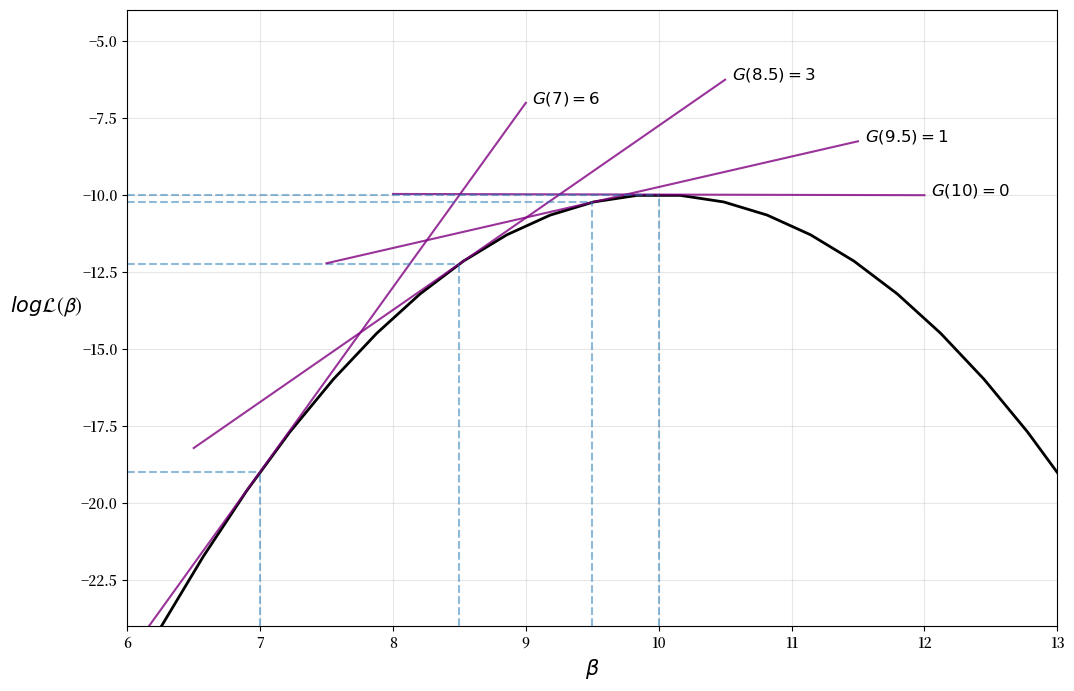

In [12]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(β, a=0.01):
    y1 = logL(β)
    y2 = logL(β+a)
    x = np.array([[β, 1], [β+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]), rcond=None)[0]
    return m, c

β = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(β, logL(β), lw=2, c='black')

for β in [7, 8.5, 9.5, 10]:
    β_line = np.linspace(β-2, β+2)
    m, c = find_tangent(β)
    y = m * β_line + c
    ax.plot(β_line, y, '-', c='purple', alpha=0.8)
    ax.text(β+2.05, y[-1], f'$G({β}) = {abs(m):.0f}$', fontsize=12)
    ax.vlines(β, -24, logL(β), linestyles='--', alpha=0.5)
    ax.hlines(logL(β), 6, β, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=25,
               fontsize=15)
ax.grid(alpha=0.3)
plt.show()

请注意，我们实现的牛顿-拉夫森算法相当基础 --- 如需更稳健的实现方案，请参考例如 [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)。

## 使用 `statsmodels` 进行最大似然估计

现在我们已经了解了其内部运作原理，我们可以将最大似然估计应用到一个有趣的应用中。

我们将使用 `statsmodels` 中的泊松回归模型来获得更丰富的输出，包括标准误差、检验值等更多信息。

`statsmodels` 使用与上述相同的算法来找到最大似然估计值。

在开始之前，让我们用 `statsmodels` 重新估计我们的简单模型，以确认我们能得到相同的系数和对数似然值。

In [13]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.2546
Time:                        23:18:38   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

现在让我们复现Daniel Treisman的论文[Russia's Billionaires](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068)中的结果，该论文在之前的讲座中提到过。

Treisman首先估计方程{eq}`poissonreg`，其中：

* $y_i$ 是 ${亿万富翁人数}_i$
* $x_{i1}$ 是 $\log{人均GDP}_i$
* $x_{i2}$ 是 $\log{人口}_i$
* $x_{i3}$ 是 ${GATT成员年限}_i$ -- 作为GATT和WTO成员的年限（用于衡量国际市场准入）

论文仅考虑2008年进行估计。

我们将按如下方式设置估计变量（你应该已经从讲座前面部分将数据赋值给了`df`）

In [14]:
# 仅保留2008年数据
df = df[df['year'] == 2008]

# 添加常数项
df['const'] = 1

# 变量集
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

然后我们可以使用`statsmodels`中的`Poisson`函数来拟合模型。

我们将像作者论文中那样使用稳健标准误

In [15]:
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9


                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.8574
Time:                        23:18:38   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.138      7.834      0.000       0.813       1.355
lnpop          1.1714      0.097     12.024      0.0

成功！算法在9次迭代后实现了收敛。

我们的输出表明，人均GDP、人口和关税贸易总协定(GATT)的成员年限与一个国家的亿万富翁数量呈正相关，这符合预期。

让我们也来估算作者的更完整模型，并将它们显示在同一个表格中

In [16]:
regs = [reg1, reg2, reg3]
reg_names = ['模型1', '模型2', '模型3']
info_dict = {'伪R方': lambda x: f"{x.prsquared:.2f}",
             '观测数': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('表1 - 解释2008年各国亿万富翁数量')
print(results_table)

           表1 - 解释2008年各国亿万富翁数量
             模型1        模型2        模型3    
------------------------------------------
const     -29.050*** -19.444*** -20.858***
          (2.578)    (4.820)    (4.255)   
lngdppc   1.084***   0.717***   0.737***  
          (0.138)    (0.244)    (0.233)   
lnpop     1.171***   0.806***   0.929***  
          (0.097)    (0.213)    (0.195)   
gattwto08 0.006      0.007      0.004     
          (0.007)    (0.006)    (0.006)   
lnmcap08             0.399**    0.286*    
                     (0.172)    (0.167)   
rintr                -0.010     -0.009    
                     (0.010)    (0.010)   
topint08             -0.051***  -0.058*** 
                     (0.011)    (0.012)   
nrrents                         -0.005    
                                (0.010)   
roflaw                          0.203     
                                (0.372)   
伪R方       0.86       0.90       0.90      
观测数       197        131        131       
Standard errors in par

输出结果表明，亿万富翁的频率与人均GDP、人口规模、股票市场市值呈正相关，与最高边际所得税率呈负相关。

为了按国家分析我们的结果，我们可以绘制预测值与实际值之间的差异，然后从高到低排序并绘制前15个国家

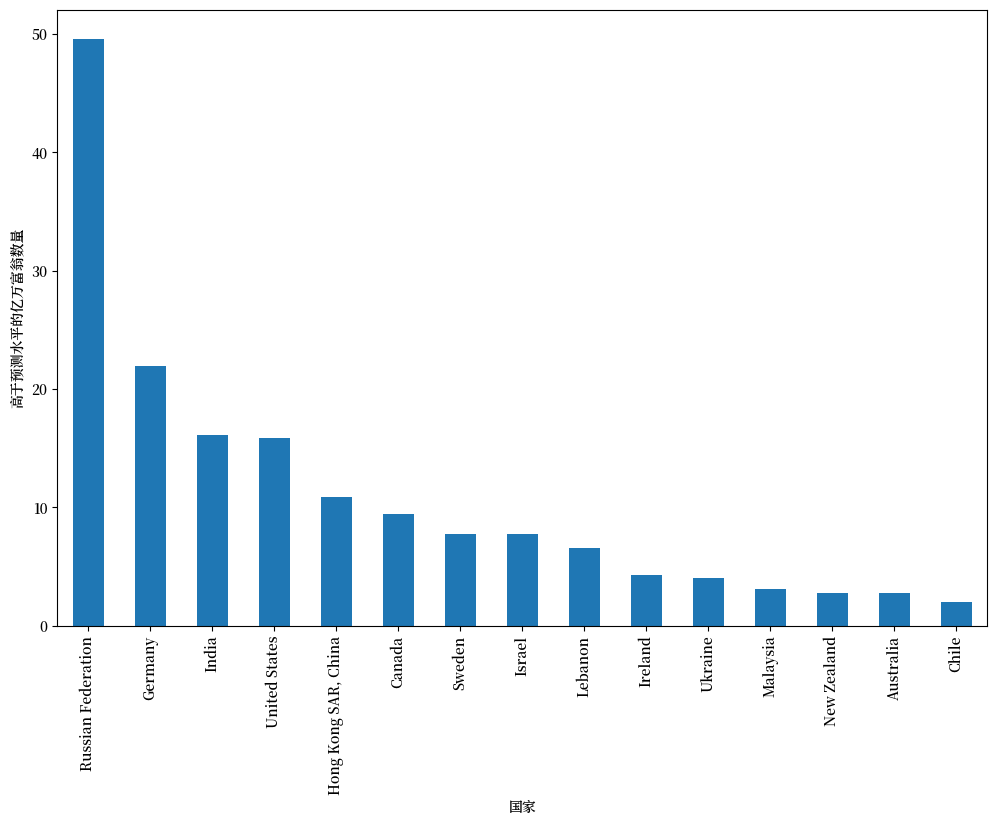

In [17]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# 使用最后一个模型（模型3）
results_df['prediction'] = results[-1].predict()

# 计算差异
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# 按降序排列
results_df.sort_values('difference', ascending=False, inplace=True)

# 绘制前15个数据点
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('高于预测水平的亿万富翁数量')
plt.xlabel('国家')
plt.show()

正如我们所见，俄罗斯的亿万富豪数量远远超出模型预测值（比预期多约50人）。

Treisman利用这一实证结果讨论了俄罗斯亿万富豪过多的可能原因，包括俄罗斯财富的来源、政治环境以及苏联解体后的私有化历史。

## 总结

在本讲中，我们使用最大似然估计法来估计泊松模型的参数。

`statsmodels`包含其他内置的似然模型，如[Probit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Probit.html)和[Logit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html)。

为了提供更大的灵活性，`statsmodels`提供了使用`GenericLikelihoodModel`类手动指定分布的方法 - 示例notebook可以在这里找到

[此处](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html)。

## 练习


```{exercise}
:label: mle_ex1

假设我们想要估计事件 $y_i$ 发生的概率，给定一些观测值。

我们可以使用概率回归模型，其中 $y_i$ 的概率质量函数为

$$
\begin{aligned}
f(y_i; \boldsymbol{\beta}) = \mu_i^{y_i} (1-\mu_i)^{1-y_i}, \quad y_i = 0,1 \\
\text{其中} \quad \mu_i = \Phi(\mathbf{x}_i' \boldsymbol{\beta})
\end{aligned}
$$

$\Phi$ 表示*累积正态分布*，它将预测的 $y_i$ 限制在0和1之间（这是概率所必需的）。

$\boldsymbol{\beta}$ 是一个系数向量。

按照讲座中的示例，编写一个类来表示Probit模型。

首先，找出对数似然函数并推导梯度和海森矩阵。

`scipy`模块中的`stats.norm`包含计算正态分布的累积分布函数和概率质量函数所需的函数。
```

```{solution-start} mle_ex1

:class: dropdown
```

对数似然函数可以写作

$$
\log \mathcal{L} = \sum_{i=1}^n
\big[
y_i \log \Phi(\mathbf{x}_i' \boldsymbol{\beta}) +
(1 - y_i) \log (1 - \Phi(\mathbf{x}_i' \boldsymbol{\beta})) \big]
$$

根据**微积分基本定理**，累积概率分布的导数是其边际分布

$$
\frac{ \partial} {\partial s} \Phi(s) = \phi(s)
$$

其中$\phi$是边际正态分布。

Probit模型的梯度向量是

$$
\frac {\partial \log \mathcal{L}} {\partial \boldsymbol{\beta}} =
\sum_{i=1}^n \Big[
y_i \frac{\phi(\mathbf{x}'_i \boldsymbol{\beta})}{\Phi(\mathbf{x}'_i \boldsymbol{\beta)}} -
(1 - y_i) \frac{\phi(\mathbf{x}'_i \boldsymbol{\beta)}}{1 - \Phi(\mathbf{x}'_i \boldsymbol{\beta)}}
\Big] \mathbf{x}_i
$$

Probit模型的Hessian矩阵是

$$
\frac {\partial^2 \log \mathcal{L}} {\partial \boldsymbol{\beta} \partial \boldsymbol{\beta}'} =
-\sum_{i=1}^n \phi (\mathbf{x}_i' \boldsymbol{\beta})

\Big[
y_i \frac{ \phi (\mathbf{x}_i' \boldsymbol{\beta}) + \mathbf{x}_i' \boldsymbol{\beta} \Phi (\mathbf{x}_i' \boldsymbol{\beta}) } { [\Phi (\mathbf{x}_i' \boldsymbol{\beta})]^2 } +
(1 - y_i) \frac{ \phi (\mathbf{x}_i' \boldsymbol{\beta}) - \mathbf{x}_i' \boldsymbol{\beta} (1 - \Phi (\mathbf{x}_i' \boldsymbol{\beta})) } { [1 - \Phi (\mathbf{x}_i' \boldsymbol{\beta})]^2 }
\Big]
\mathbf{x}_i \mathbf{x}_i'
$$

根据这些结果，我们可以按如下方式编写Probit模型的类

In [18]:
class ProbitRegression:

    def __init__(self, y, X, β):
        self.X, self.y, self.β = X, y, β
        self.n, self.k = X.shape

    def μ(self):
        return norm.cdf(self.X @ self.β.T)

    def ϕ(self):
        return norm.pdf(self.X @ self.β.T)

    def logL(self):
        μ = self.μ()
        return np.sum(y * np.log(μ) + (1 - y) * np.log(1 - μ))

    def G(self):
        μ = self.μ()
        ϕ = self.ϕ()
        return np.sum((X.T * y * ϕ / μ - X.T * (1 - y) * ϕ / (1 - μ)),
                     axis=1)

    def H(self):
        X = self.X
        β = self.β
        μ = self.μ()
        ϕ = self.ϕ()
        a = (ϕ + (X @ β.T) * μ) / μ**2
        b = (ϕ - (X @ β.T) * (1 - μ)) / (1 - μ)**2
        return -(ϕ * (y * a + (1 - y) * b) * X.T) @ X

```{solution-end}
```

```{exercise-start}
:label: mle_ex2
```

使用以下数据集和$\boldsymbol{\beta}$的初始值，用课程前面介绍的牛顿-拉夫森算法来估计最大似然估计

$$
\mathbf{X} =
\begin{bmatrix}
1 & 2 & 4 \\
1 & 1 & 1 \\
1 & 4 & 3 \\
1 & 5 & 6 \\
1 & 3 & 5
\end{bmatrix}
\quad
y =
\begin{bmatrix}
1 \\
0 \\
1 \\
1 \\
0
\end{bmatrix}
\quad
\boldsymbol{\beta}_{(0)} =
\begin{bmatrix}
0.1 \\
0.1 \\
0.1
\end{bmatrix}
$$

使用`statsmodels`验证你的结果 - 你可以用以下导入语句导入Probit函数

In [19]:
from statsmodels.discrete.discrete_model import Probit

请注意，本讲中开发的简单牛顿-拉夫森算法对初始值非常敏感，因此使用不同的起始值可能无法实现收敛。

```{exercise-end}
```

```{solution-start} mle_ex2
:class: dropdown
```

这是一个解决方案

In [20]:
X = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])

# 对β初始值进行猜测
β = np.array([0.1, 0.1, 0.1])

# 创建Probit回归类的实例
prob = ProbitRegression(y, X, β)

# 运行牛顿-拉夫森算法
newton_raphson(prob)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -2.3796884      ['-1.34', '0.775', '-0.157']
1            -2.3687526      ['-1.53', '0.775', '-0.0981']
2            -2.3687294      ['-1.55', '0.778', '-0.0971']
3            -2.3687294      ['-1.55', '0.778', '-0.0971']
迭代次数：4
β_hat = [-1.54625858  0.77778952 -0.09709757]


array([-1.54625858,  0.77778952, -0.09709757])

In [21]:
# 使用statsmodels验证结果

print(Probit(y, X).fit().summary())

Optimization terminated successfully.
         Current function value: 0.473746
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                         Probit   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.2961
Time:                        23:18:38   Log-Likelihood:                -2.3687
converged:                       True   LL-Null:                       -3.3651
Covariance Type:            nonrobust   LLR p-value:                    0.3692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5463      1.866     -0.829      0.407      -5.204       2.111
x1             0.7778      0.

```{solution-end}
```